# Preprocessing 

In [1]:
import pandas as pd
import warnings
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)


In [10]:
# read data
print(f"Importing data...")
cv_df = pd.read_csv("../results/ClinVar_preprocessed.csv.gz", compression='gzip', low_memory=0, na_values=['?'])

print(f"{cv_df.shape[0]} ClinVar variants before filtering.")

cv_df.rename(columns={'SM.ClassRIN': 'SimpleClassRIN'}, inplace=True)

# filter variants
cv_df = cv_df[cv_df["CV.SigShort"] != "VUS"]
print(f"{cv_df.shape[0]} ClinVar variants after removal of 'VUS'.")

cv_df = cv_df[cv_df["CV.SigShort"] != "Drug response"]
print(f"{cv_df.shape[0]} ClinVar variants after removal of 'Drug response'.")

# add an indicator column for CPD
# cv_df["CPD"] = cv_df["NumAA2in26Prim"].apply(lambda x: x > 0 if ~np.isnan(x) else np.nan)
# cv_df["CPD"] = cv_df["CPD"].map({True: 'CPD', False: 'non-CPD'})

# map sctructure classes to groups
cv_df["SimpleClassRIN"] = cv_df["SimpleClassRIN"].map({
    'Protein interaction': 'Protein_interaction', 
    'Surface': 'Surface',
    'Core': 'Core',
    'ligand interaction': 'Other_interactions',
    'DNA interaction': 'Other_interactions',
    'ion interaction': 'Other_interactions',
    'metal interaction': 'Other_interactions',
    'RNA interaction': 'Other_interactions',
    'Disorder': 'None',
    'None': 'None'
})

# save features
PHYL_FEAT = ["PhyloP", "SPOTD.Info", "PPH.dScore", "Blosum62", "PPH.PHAT", "Grantham", 'SubDiffKDHydro']
STRUCT_FEAT = ["dProp", "dVol", "AveSeqDist", "SPOTD.CN", "SPOTD.HSEu", "SPOTD.HSEd", "SPOTD.ASA", "DSSP.NormASA", "B.Mean",
               "B.Zscore", "IntCont", "ExtCont", "BiolHetCont", "Hb.Tot", "Hb.Inter", "Hb.Intra", "Hb.IntraDist", "Hb.SM", "Hb.SS",
               'SPOTD.PDisorder', 'SPOTD.PCoil', 'SPOTD.PSheet', 'SPOTD.PHelix']
DDG_FEAT = ["MaestroddG", "FoldXddG"]
CLASS_FEAT = ['SimpleClassRIN', 'CV.SigShort']#, "CPD"]
# SEL_FEAT = ["PhyloP", "PPH.dScore", 
#             "AveSeqDist", "DSSP.NormASA", "B.Mean", "B.Zscore", "IntCont", "FoldXddG"]
SEL_FEAT = ["PhyloP", "SPOTD.Info", "PPH.dScore", "Grantham",
            "DSSP.NormASA", "B.Zscore", "IntCont", "FoldXddG"]


print("\nNumber of variants in df with:")

# a df with phylogenetic features (no filter)
cv_df_phyl = cv_df[PHYL_FEAT + CLASS_FEAT]#.dropna()
cv_df_phyl[PHYL_FEAT] = cv_df_phyl[PHYL_FEAT].apply(pd.to_numeric)
print(f"- Phyl features: {cv_df_phyl.shape[0]}.")

# a df with structural features (no ddG) (PDBAAMatch filter)
cv_df_struct = cv_df[cv_df["PDBAAMatch"] == 1][STRUCT_FEAT + CLASS_FEAT]#.dropna()
cv_df_struct[STRUCT_FEAT] = cv_df_struct[STRUCT_FEAT].apply(pd.to_numeric)
print(f"- Struct (no ddG) features: {cv_df_struct.shape[0]}.")

# a df with structural features (no ddG) (PDBAAMatch filter)
cv_df_str_phyl = cv_df[cv_df["PDBAAMatch"] == 1][PHYL_FEAT + STRUCT_FEAT + CLASS_FEAT]#.dropna()
cv_df_str_phyl[PHYL_FEAT + STRUCT_FEAT] = cv_df_str_phyl[PHYL_FEAT + STRUCT_FEAT].apply(pd.to_numeric, errors='coerce')
print(f"- Phyl & struct (no ddG) features: {cv_df_str_phyl.shape[0]}.")

# a df with all features (high quality mapping filter)
cv_df_all = cv_df[(cv_df["PDBAAMatch"] == 1) & 
                  (cv_df['SM.Ide'] >= 0.95) & 
                  (cv_df['SM.Coverage'] >= 0.5)]
cv_df_all['SM.Resol'] = cv_df_all['SM.Resol'].astype("float")
cv_df_all = cv_df_all[(cv_df_all['SM.Resol'] <= 4.5)]
cv_df_all = cv_df_all[PHYL_FEAT + STRUCT_FEAT + DDG_FEAT + CLASS_FEAT]#.dropna()
cv_df_all[PHYL_FEAT + STRUCT_FEAT + DDG_FEAT] = cv_df_all[PHYL_FEAT + STRUCT_FEAT + DDG_FEAT].apply(pd.to_numeric, errors='coerce')
print(f"- All features: {cv_df_all.shape[0]}.")

# # a df with selected features (high quality mapping filter)
# cv_df_sel = cv_df[(cv_df["PDBAAMatch"] == 1) & 
#                   (cv_df['SM.Ide'] >= 0.95) & 
#                   (cv_df['SM.Coverage'] >= 0.5)]
# cv_df_sel['SM.Resol'] = cv_df_sel['SM.Resol'].astype("float")
# cv_df_sel = cv_df_sel[(cv_df_sel['SM.Resol'] <= 4.5)]
# cv_df_sel = cv_df_sel[SEL_FEAT + CLASS_FEAT].dropna()
# cv_df_sel[SEL_FEAT] = cv_df_sel[SEL_FEAT].apply(pd.to_numeric, errors='coerce')
# print(f"- All features: {cv_df_sel.shape[0]}.")


Importing data...
216255 ClinVar variants before filtering.
50968 ClinVar variants after removal of 'VUS'.
50798 ClinVar variants after removal of 'Drug response'.

Number of variants in df with:
- Phyl features: 50798.
- Struct (no ddG) features: 25456.
- Phyl & struct (no ddG) features: 25456.
- All features: 10827.


In [8]:
cv_df_all.isna().sum(axis=0)

PhyloP                 0
SPOTD.Info            66
PPH.dScore             0
Blosum62               0
PPH.PHAT           10268
Grantham               0
SubDiffKDHydro         0
dProp                201
dVol                 201
AveSeqDist           194
SPOTD.CN              66
SPOTD.HSEu            66
SPOTD.HSEd            66
SPOTD.ASA             66
DSSP.NormASA         201
B.Mean               201
B.Zscore             201
IntCont              194
ExtCont              194
BiolHetCont          194
Hb.Tot               201
Hb.Inter             201
Hb.Intra             201
Hb.IntraDist         201
Hb.SM                201
Hb.SS                201
SPOTD.PDisorder       66
SPOTD.PCoil           66
SPOTD.PSheet          66
SPOTD.PHelix          66
MaestroddG           195
FoldXddG             224
SimpleClassRIN         0
CV.SigShort            0
dtype: int64

# Correlation

In [4]:
def plot_corr(df, coef="pearson"):
    # Compute the correlation matrix
    corr = df.corr(coef)
    triu_corr = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
    # # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .6});
    return triu_corr

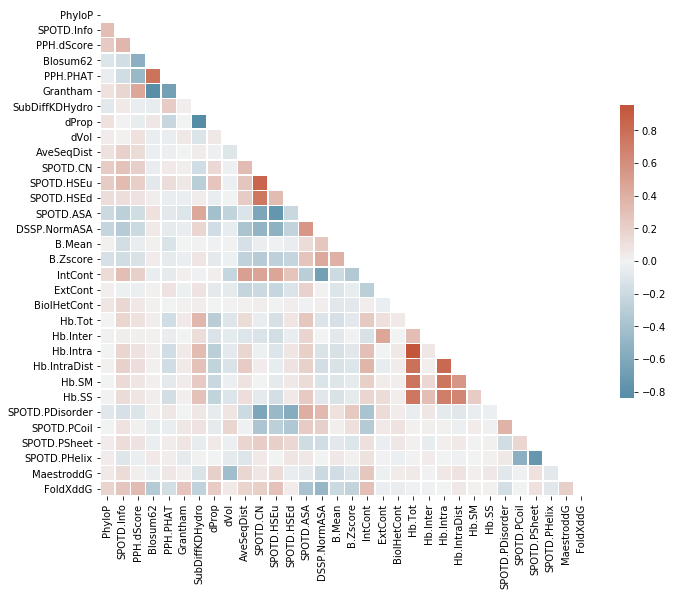

In [23]:
corr_df = plot_corr(cv_df_all.drop(columns=['SimpleClassRIN', 'CV.SigShort']), "spearman")

In [24]:
corr_df

,PhyloP,SPOTD.Info,PPH.dScore,Blosum62,PPH.PHAT,Grantham,SubDiffKDHydro,dProp,dVol,AveSeqDist,...,Hb.Intra,Hb.IntraDist,Hb.SM,Hb.SS,SPOTD.PDisorder,SPOTD.PCoil,SPOTD.PSheet,SPOTD.PHelix,MaestroddG,FoldXddG
PhyloP,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPOTD.Info,0.313713,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PPH.dScore,0.240389,0.358245,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Blosum62,-0.104347,-0.159034,-0.539446,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PPH.PHAT,-0.043704,-0.164083,-0.474961,0.771359,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Grantham,0.101801,0.169185,0.460070,-0.815854,-0.670923,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SubDiffKDHydro,-0.079303,0.048249,-0.040780,-0.051736,0.226947,0.029365,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dProp,0.103392,0.005210,-0.048609,0.064169,-0.221088,-0.004414,-0.841270,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dVol,0.033234,0.009996,0.105661,-0.047379,-0.038707,0.053721,-0.117863,0.051965,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AveSeqDist,0.097471,0.193461,0.127901,-0.026056,-0.022536,0.000324,0.029619,-0.013546,-0.093957,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
corr_df.to_csv("../results/spearman_correlations_all.csv")

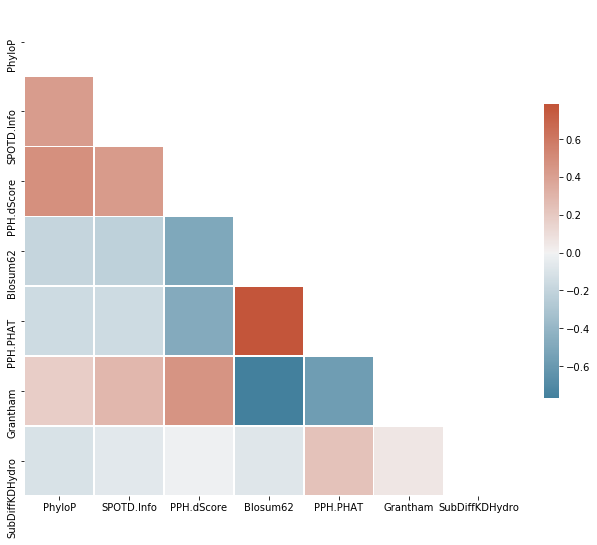

In [19]:
corr_df = plot_corr(cv_df_phyl.drop(columns=['SimpleClassRIN', 'CV.SigShort']));
corr_df.to_csv("../results/spearman_correlations_phyl.csv")

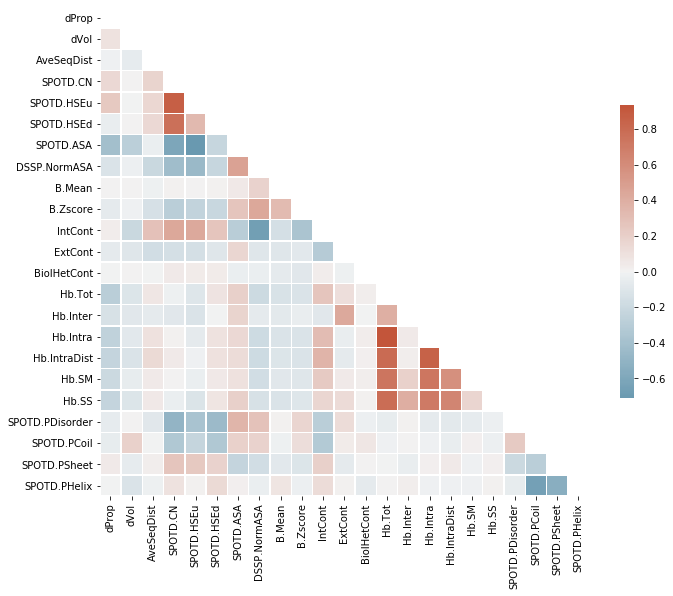

In [20]:
corr_df = plot_corr(cv_df_struct.drop(columns=['SimpleClassRIN', 'CV.SigShort']));
corr_df.to_csv("../results/spearman_correlations_str.csv")

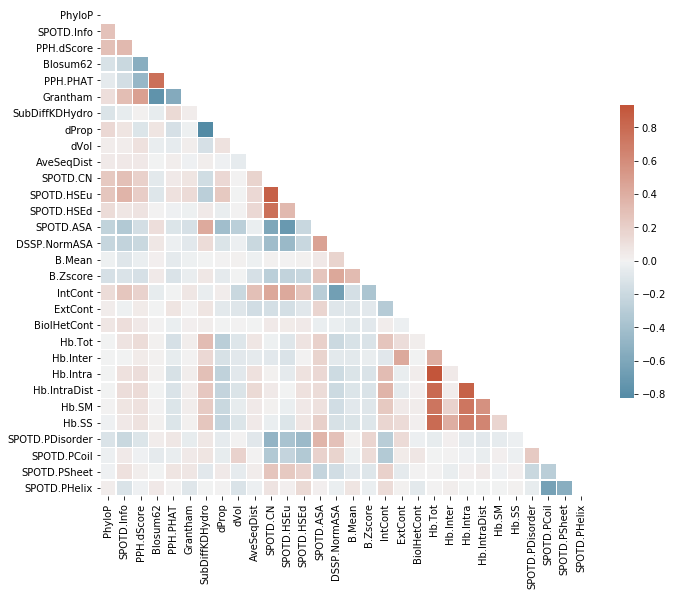

In [21]:
corr_df = plot_corr(cv_df_str_phyl.drop(columns=['SimpleClassRIN', 'CV.SigShort']));
corr_df.to_csv("../results/spearman_correlations_str_phyl.csv")

# DimReduction

In [92]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D

PALETTE = {"Benign": "mediumseagreen", "Ben-CPD": "seagreen", "Ben-nonCPD": "yellowgreen", 
           "Pathogenic": "r", "Path-CPD": "lightsalmon", "Path-nonCPD": "indianred",
           'Protein_interaction': "darksalmon", 'Other_interactions': 'mediumpurple',
           'Surface': "steelblue", 'Core': 'mediumaquamarine', "CPD": "seagreen", "non-CPD": "darksalmon"}
    
    
def plot_PCA(df, scale_X=True, three_dim=False, plot_by=None):
    
    if three_dim: pca = PCA(n_components=3)
    else: pca = PCA(n_components=2)

    if scale_X: X = scale(df.drop(columns=CLASS_FEAT).values)
    else: X = df.drop(columns=CLASS_FEAT).values
    
    pca_result = pca.fit_transform(X)
        
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    
    if three_dim:        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection = '3d')

        x = pca_result[:,0]
        y = pca_result[:,1] 
        z = pca_result[:,2] 

        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        
        if plot_by:
            c = df[plot_by].map({"Benign": 0, "Pathogenic": 1, 
                                 'Protein_interaction': 2, 'Other_interactions': 3,
                                 'Surface': 4, 'Core': 5, "CPD": 6, "non-CPD": 7})
            ax.scatter(x, y, z, c=c)
        else: 
            ax.scatter(x, y, z)
    else:
        df['PC1'] = pca_result[:,0]
        df['PC2'] = pca_result[:,1] 
        plt.figure(figsize=(10,10))
        sns.scatterplot(data=df, x="PC1", y="PC2", hue=plot_by, palette=PALETTE);
    
    return

Explained variation per principal component: [0.37985124 0.24157838 0.09286354]


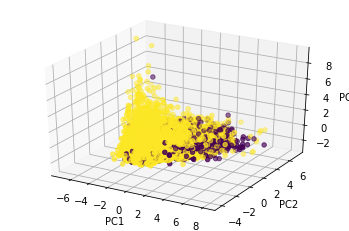

In [94]:
plot_PCA(cv_df_sel, plot_by="CV.SigShort", three_dim=True)

Explained variation per principal component: [0.37985124 0.24157838]


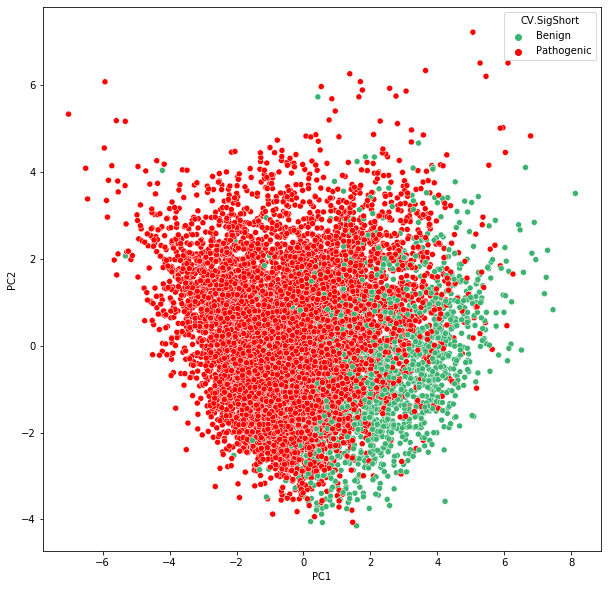

In [95]:
plot_PCA(cv_df_sel, plot_by="CV.SigShort")

In [70]:
def plot_tSNE(df, scale_X=True, plot_by=None):
    pca = PCA(n_components=3)
    
    if scale_X: X = scale(df.drop(columns=CLASS_FEAT).values)
    else: X = df.drop(columns=CLASS_FEAT).values
    tsne = TSNE(perplexity=100, n_components=2, verbose=1, n_iter=300)
    tsne_results = tsne.fit_transform(X)
        
    df['TSNE1'] = tsne_results[:,0]
    df['TSNE2'] = tsne_results[:,1] 
    
    plt.figure(figsize=(10,10))
    sns.scatterplot(data=df, x="TSNE1", y="TSNE2", hue=plot_by, palette=PALETTE);

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10030 samples in 0.008s...
[t-SNE] Computed neighbors for 10030 samples in 3.321s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10030
[t-SNE] Computed conditional probabilities for sample 2000 / 10030
[t-SNE] Computed conditional probabilities for sample 3000 / 10030
[t-SNE] Computed conditional probabilities for sample 4000 / 10030
[t-SNE] Computed conditional probabilities for sample 5000 / 10030
[t-SNE] Computed conditional probabilities for sample 6000 / 10030
[t-SNE] Computed conditional probabilities for sample 7000 / 10030
[t-SNE] Computed conditional probabilities for sample 8000 / 10030
[t-SNE] Computed conditional probabilities for sample 9000 / 10030
[t-SNE] Computed conditional probabilities for sample 10000 / 10030
[t-SNE] Computed conditional probabilities for sample 10030 / 10030
[t-SNE] Mean sigma: 0.829133
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.612534
[t-SNE] KL

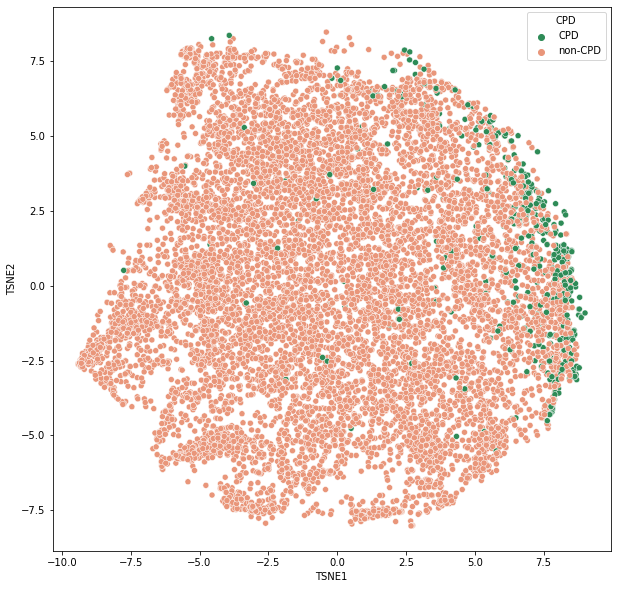

In [71]:
plot_tSNE(cv_df_sel, plot_by="CPD")